# **Avalanche Risk Project**

Advanced Data Analytics, Fall 2025

The following project examines the feasibility of deep learning models (3D-CNN, convLSTM) compared to traditional, state-of-the-art methods for predicting avalanche danger levels. Using a comprehensive dataset from the Swiss Federal Institute for Snow and Avalanche Research (SLF) spanning from 1997-2020, the project heavily relies on the work of Pérez-Guillén et al. (2022) and Maissen et al. (2024) and adopts many of their preprocessing and modeling techniques.

In [1]:
import requests
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

## **2. Exploratory Data Analysis (EDA)**

In [2]:
imis_df = pd.read_csv('data/imis_df_cleaned.csv')


In [3]:
imis_df

,datum,station_code,sector_id,warnreg,elevation_station,forecast_initial_date,forecast_end_date,dangerLevel,elevation_th,set,...,ccl_pwl,ssi_pwl_100,sk38_pwl_100,sn38_pwl_100,ccl_pwl_100,Pen_depth,min_ccl_pen,lon,lat,delta_elevation
0,2019-11-15,ALB2,5231.0,21.0,2300.0,2019-11-15 17:00:00,2019-11-16 17:00:00,3.0,2200.0,test,...,0.25,1.61,0.61,0.98,0.25,34.402762,0.18,9.836224,46.580945,100.0
1,2019-11-16,ALB2,5231.0,21.0,2300.0,2019-11-16 17:00:00,2019-11-17 17:00:00,3.0,2200.0,test,...,0.28,1.76,0.76,1.05,0.28,35.092922,0.20,9.836224,46.580945,100.0
2,2019-11-17,ALB2,5231.0,21.0,2300.0,2019-11-17 17:00:00,2019-11-18 17:00:00,3.0,2000.0,test,...,0.34,0.94,0.85,1.08,0.34,26.587603,0.23,9.836224,46.580945,300.0
3,2019-11-18,ALB2,5231.0,21.0,2300.0,2019-11-18 17:00:00,2019-11-19 17:00:00,3.0,2200.0,test,...,0.40,1.93,0.93,1.19,0.40,22.648569,0.30,9.836224,46.580945,100.0
4,2019-11-19,ALB2,5231.0,21.0,2300.0,2019-11-19 17:00:00,2019-11-20 17:00:00,3.0,2200.0,test,...,0.43,2.01,1.01,1.28,0.43,21.163923,0.32,9.836224,46.580945,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291866,2020-04-29,ZNZ2,7123.0,21.0,2700.0,2020-04-29 17:00:00,2020-04-30 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,10.363926,1.08,10.018844,46.697716,300.0
291867,2020-04-30,ZNZ2,7123.0,21.0,2700.0,2020-04-30 17:00:00,2020-05-01 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,13.866200,0.38,10.018844,46.697716,300.0
291868,2020-05-01,ZNZ2,7123.0,21.0,2700.0,2020-05-01 17:00:00,2020-05-02 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,14.396211,0.36,10.018844,46.697716,300.0
291869,2020-05-02,ZNZ2,7123.0,21.0,2700.0,2020-05-02 17:00:00,2020-05-03 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,16.123371,0.35,10.018844,46.697716,300.0


### **2.1 Target Variable Analysis**

We start with a temporal and spatial analysis of the target variable, `dangerLevel`, to understand its distribution across different stations and over time.

In [4]:
# Convert datum to datetime
imis_df['datum'] = pd.to_datetime(imis_df['datum'])
imis_df['month'] = imis_df['datum'].dt.month
imis_df['year'] = imis_df['datum'].dt.year

avalanche_season = imis_df[imis_df['month'].isin([11, 12, 1, 2, 3, 4, 5])].copy()

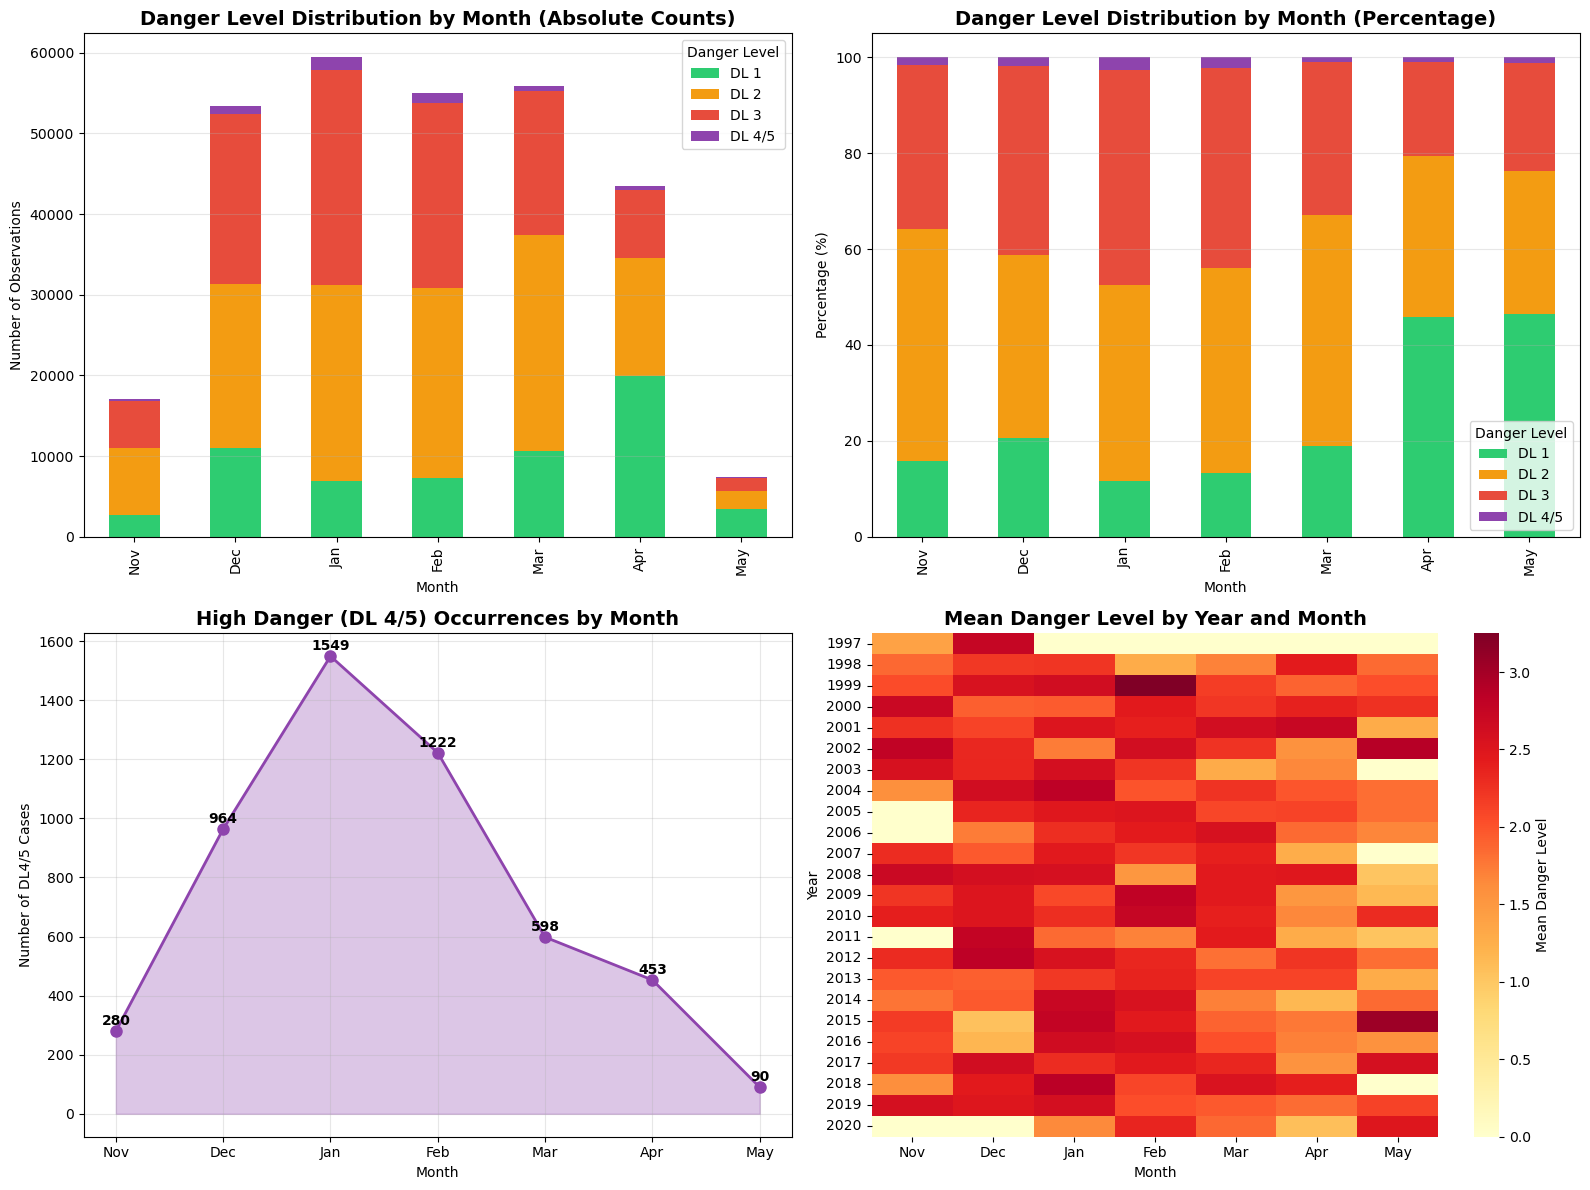

In [ ]:
# Monthly Danger Level Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Absolute Counts
monthly_counts = avalanche_season.groupby(['month', 'dangerLevel']).size().unstack(fill_value=0)
month_names = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
monthly_counts.index = monthly_counts.index.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                                   3: 'Mar', 4: 'Apr', 5: 'May'})
monthly_counts = monthly_counts.reindex(month_names)

monthly_counts.plot(kind='bar', stacked=True, ax=axes[0, 0], 
                    color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
axes[0, 0].set_title('Danger Level Distribution by Month (Absolute Counts)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Observations')
axes[0, 0].legend(title='Danger Level', labels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Percentages
monthly_pct = avalanche_season.groupby(['month', 'dangerLevel']).size().unstack(fill_value=0)
monthly_pct = monthly_pct.div(monthly_pct.sum(axis=1), axis=0) * 100
monthly_pct.index = monthly_pct.index.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                            3: 'Mar', 4: 'Apr', 5: 'May'})
monthly_pct = monthly_pct.reindex(month_names)

monthly_pct.plot(kind='bar', stacked=True, ax=axes[0, 1],
                 color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
axes[0, 1].set_title('Danger Level Distribution by Month (Percentage)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].legend(title='Danger Level', labels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Line Plot - Danger Level 4 Ocurrences
dl4_by_month = avalanche_season[avalanche_season['dangerLevel'] == 4].groupby('month').size()
dl4_by_month.index = dl4_by_month.index.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                               3: 'Mar', 4: 'Apr', 5: 'May'})
dl4_by_month = dl4_by_month.reindex(month_names, fill_value=0)

axes[1, 0].plot(dl4_by_month.index, dl4_by_month.values, marker='o', 
                linewidth=2, markersize=8, color='#8e44ad')
axes[1, 0].fill_between(range(len(month_names)), dl4_by_month.values, alpha=0.3, color='#8e44ad')
axes[1, 0].set_title('High Danger (DL 4/5) Occurrences by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of DL4/5 Cases')
axes[1, 0].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(dl4_by_month.values):
    axes[1, 0].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

# 4. Heatmap - Danger Level by month and year
yearly_monthly = avalanche_season.groupby(['year', 'month'])['dangerLevel'].mean().unstack(fill_value=0)
yearly_monthly.columns = yearly_monthly.columns.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                                       3: 'Mar', 4: 'Apr', 5: 'May'})
yearly_monthly = yearly_monthly[month_names]

sns.heatmap(yearly_monthly, cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Mean Danger Level'})
axes[1, 1].set_title('Mean Danger Level by Year and Month', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Year')

plt.tight_layout()
plt.show()

Based on the visualization provided, here's a brief analysis of the avalanche danger level distribution:

- Seasonal Peak: High danger levels (DL 4/5) peak significantly in January (1549 cases) and February (1222 cases), aligning with peak winter conditions. This confirms that any validation set must include these months to properly test a model's ability to predict high danger.

- Shoulder Seasons: November and May have very few high-danger cases, dominated instead by lower danger levels (DL 1/2). This suggests different meteorological drivers in early/late season compared to mid-winter.

- Yearly Variability: The heatmap (bottom right) shows clear inter-annual variability. Some years (e.g., 1999, 2018) had intense, prolonged high-danger periods (dark red), while others (e.g., 2011, 2020) were notably milder (lighter colors). A robust model will need to capture these broad seasonal trends.

- Dominant Classes: Throughout the core winter (Dec-Mar), Danger Level 3 (Considerable, red) and Danger Level 2 (Moderate, orange) consistently make up the vast majority of all forecasts, reinforcing the class imbalance challenge.

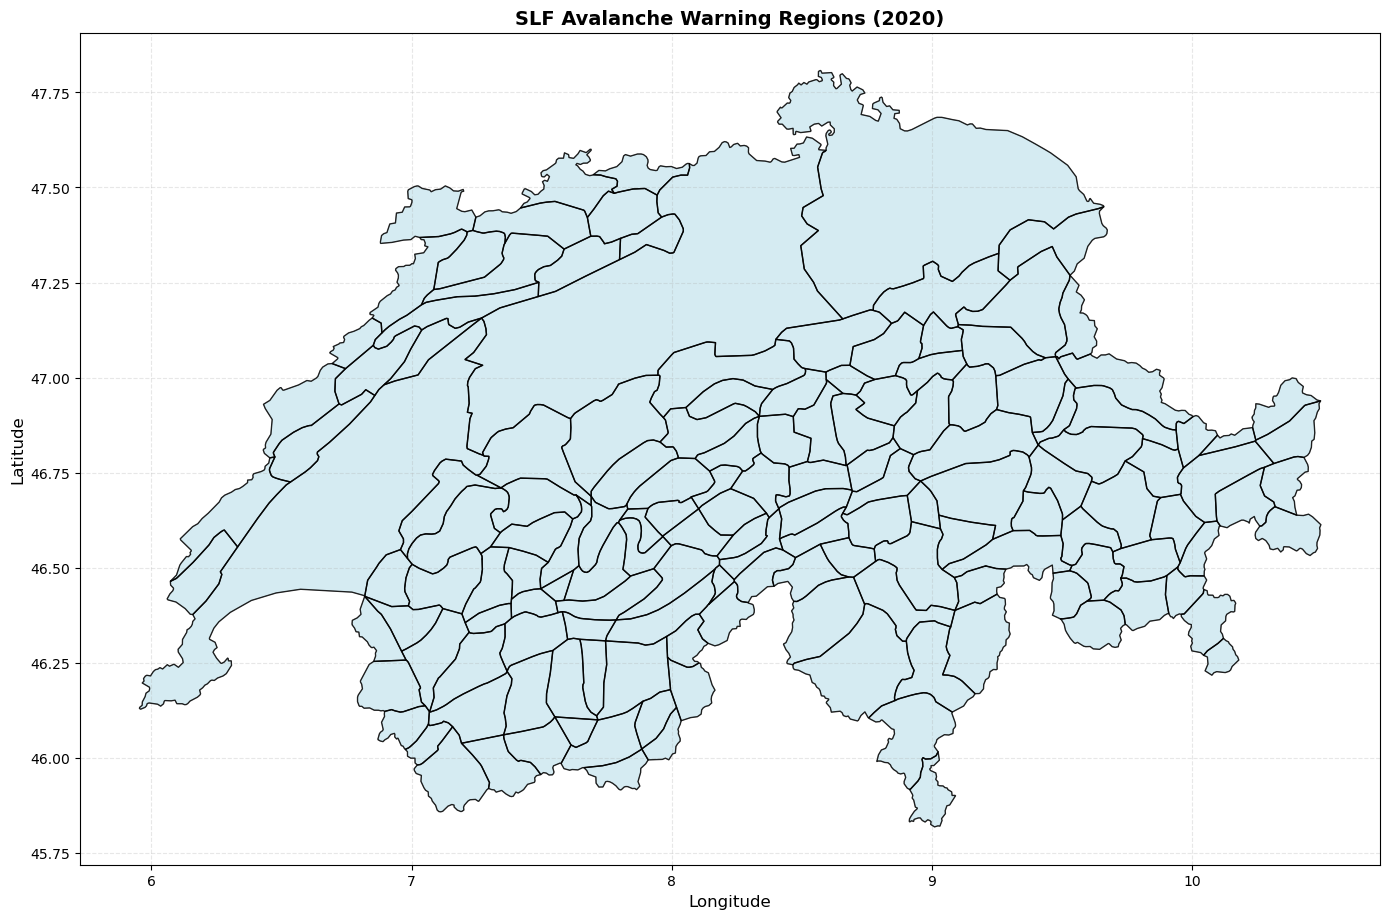


Total warning regions: 149


In [6]:
# Plot SLF warning region boundaries
slf_bounds = gpd.read_file('data/slf_boundaries_2020.json')

# Create the plot
fig, ax = plt.subplots(figsize=(14, 12))

# Plot boundaries
slf_bounds.boundary.plot(ax=ax, color='black', linewidth=1, alpha=0.8)
slf_bounds.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)
ax.set_title('SLF Avalanche Warning Regions (2020)', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Show summary statistics
print(f"\nTotal warning regions: {len(slf_bounds)}")

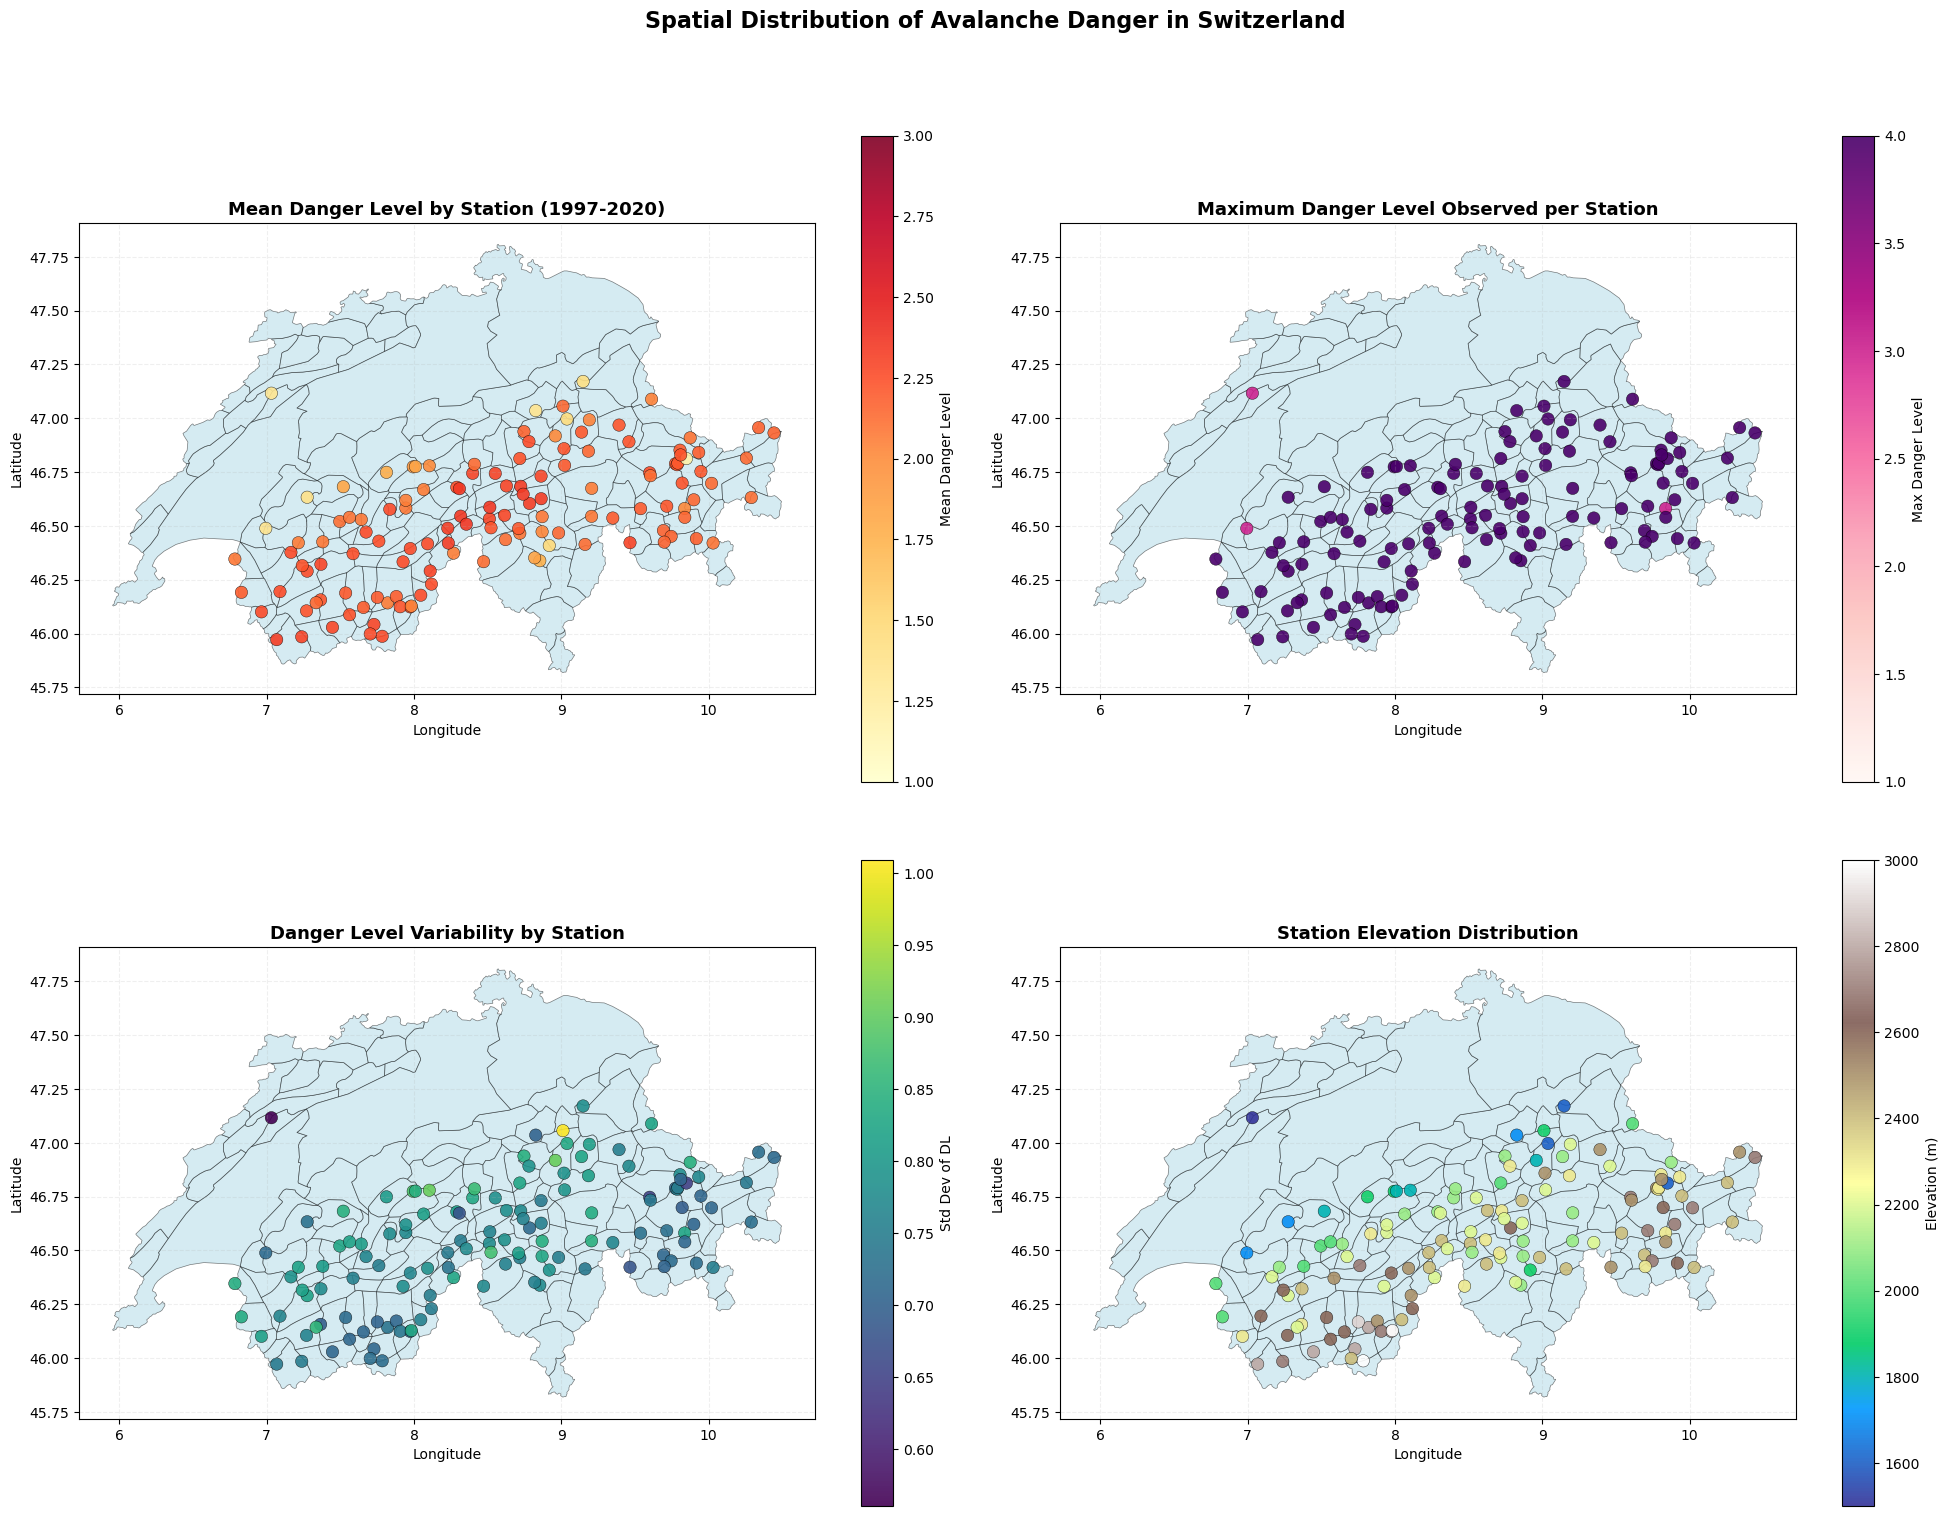

In [ ]:
# Station statistics
station_stats = imis_df.groupby('station_code').agg({
    'dangerLevel': ['mean', 'std', 'max', 'count'],
    'lon': 'first',
    'lat': 'first',
    'elevation_station': 'first',
    'warnreg': 'first'
}).reset_index()

station_stats.columns = ['station_code', 'mean_DL', 'std_DL', 'max_DL', 'n_obs', 
                          'lon', 'lat', 'elevation', 'warnreg']

# Spatial Distribution of Danger Levels
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Spatial Distribution of Avalanche Danger in Switzerland', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Mean Danger Level by Station
ax1 = axes[0, 0]
slf_bounds.plot(ax=ax1, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)
scatter1 = ax1.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.mean_DL, cmap='YlOrRd',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9,
    vmin=1, vmax=3
)
plt.colorbar(scatter1, ax=ax1, shrink=0.8, label='Mean Danger Level')
ax1.set_title('Mean Danger Level by Station (1997-2020)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True, alpha=0.2, linestyle='--')

# 2. Maximum Danger Level by Station
ax2 = axes[0, 1]
slf_bounds.plot(ax=ax2, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)
scatter2 = ax2.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.max_DL, cmap='RdPu',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9,
    vmin=1, vmax=4
)
plt.colorbar(scatter2, ax=ax2, shrink=0.8, label='Max Danger Level')
ax2.set_title('Maximum Danger Level Observed per Station', fontsize=13, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True, alpha=0.2, linestyle='--')

# 3. Danger Level Variability 
ax3 = axes[1, 0]
slf_bounds.plot(ax=ax3, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)
scatter3 = ax3.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.std_DL, cmap='viridis',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9
)
plt.colorbar(scatter3, ax=ax3, shrink=0.8, label='Std Dev of DL')
ax3.set_title('Danger Level Variability by Station', fontsize=13, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.grid(True, alpha=0.2, linestyle='--')

# 4. Elevation-Coded Stations
ax4 = axes[1, 1]
slf_bounds.plot(ax=ax4, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)
scatter4 = ax4.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.elevation, cmap='terrain',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9
)
plt.colorbar(scatter4, ax=ax4, shrink=0.8, label='Elevation (m)')
ax4.set_title('Station Elevation Distribution', fontsize=13, fontweight='bold')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.show()

# ...existing code for regional analysis...

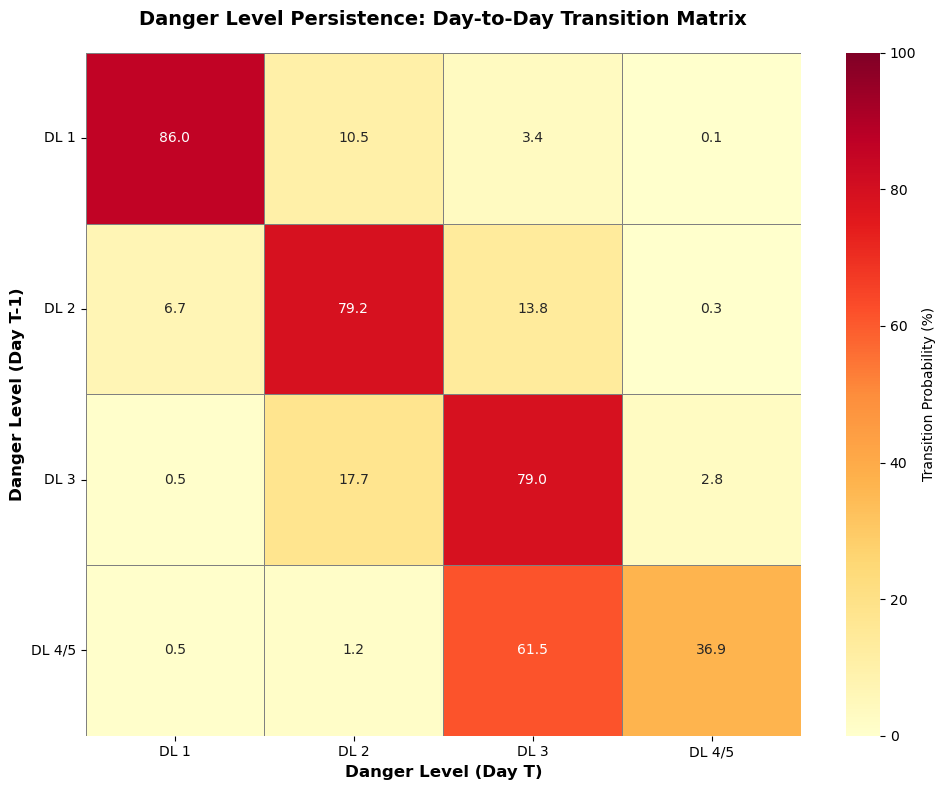

In [11]:
# Danger Level Persistence - Transition Matrix
avalanche_season_sorted = avalanche_season.sort_values(['station_code', 'datum']).copy()
avalanche_season_sorted['dangerLevel_prev'] = avalanche_season_sorted.groupby('station_code')['dangerLevel'].shift(1)
transitions = avalanche_season_sorted.dropna(subset=['dangerLevel_prev']).copy()

# Transition matrix calculation
transition_matrix = pd.crosstab(
    transitions['dangerLevel_prev'], 
    transitions['dangerLevel'],
    normalize='index'  
) * 100  

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    transition_matrix, 
    annot=True,  # Show percentages in cells
    fmt='.1f',   # One decimal place
    cmap='YlOrRd',
    cbar_kws={'label': 'Transition Probability (%)'},
    linewidths=0.5,
    linecolor='gray',
    vmin=0,
    vmax=100,
    ax=ax
)

ax.set_title('Danger Level Persistence: Day-to-Day Transition Matrix', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Danger Level (Day T)', fontsize=12, fontweight='bold')
ax.set_ylabel('Danger Level (Day T-1)', fontsize=12, fontweight='bold')
ax.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'], rotation=0)
ax.set_yticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'], rotation=0)

plt.tight_layout()
plt.show()


The transition matrix reveals that a naïve "persistence" model (predicting today's danger level is the same as yesterday's) achieves an overall accuracy of 79.8%.

While this baseline seems very high, the matrix also reveals its critical weakness:

Fails at High Danger: The model is least stable for DL 4/5, only persisting 36.9% of the time.

Fails to Stabilize: Most importantly, on the day after a DL 4/5 event, the danger level drops to DL 3 in 61.5% of cases. The naïve model will be wrong in all these high-risk stabilization scenarios.

Value Proposition: This baseline highlights that the "easy" 80% of days are not the problem. The challenge is to correctly predict the 20% of days when the danger level changes.

This aligns perfectly with the findings of Pérez-Guillén et al. (2022). They tested a Random Forest (RF 1*) that included the previous day's forecast as a feature. While its overall accuracy jumped to 82%, it failed catastrophically at predicting change:

Its accuracy dropped to 43% on days when the danger increased.

Its accuracy dropped to 29% on days when the danger decreased.

Conclusion: Our naïve baseline (79.8%) and their RF 1* (82%) are essentially the same "persistence" model. They are accurate on stable days but fail on critical transition days.

Therefore, the success of our RF and 3D CNN models should not be measured just by their ability to beat 79.8% overall, but by their significantly improved accuracy on "transition days", especially in predicting the onset and stabilization of high-danger events.

In [12]:
# Calculate Baseline Model Performance Metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix

print("\n" + "="*80)
print("NAÏVE PERSISTENCE BASELINE: Performance Metrics")
print("="*80)
print("\nModel: Predict today's danger level = yesterday's danger level")
print("-" * 80)

# Overall metrics
y_true = transitions['dangerLevel'].values
y_pred = transitions['dangerLevel_prev'].values

accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"\n{'OVERALL METRICS':^80}")
print("-" * 80)
print(f"  Accuracy:                 {accuracy*100:6.2f}%")
print(f"  Balanced Accuracy:        {balanced_acc*100:6.2f}%")
print(f"  F1-Score (Macro):         {f1_macro:6.3f}")
print(f"  F1-Score (Weighted):      {f1_weighted:6.3f}")

# Per-class metrics
print(f"\n{'PER-CLASS METRICS':^80}")
print("-" * 80)
print(f"{'Danger Level':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 80)

for dl in [1, 2, 3, 4]:
    # Calculate metrics for this class
    y_true_binary = (y_true == dl).astype(int)
    y_pred_binary = (y_pred == dl).astype(int)
    
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    support = y_true_binary.sum()
    
    print(f"DL {dl:<12} {precision:>10.3f}  {recall:>10.3f}  {f1:>10.3f}  {support:>8,}")

# Confusion Matrix
print(f"\n{'CONFUSION MATRIX (Normalized by True Label)':^80}")
print("-" * 80)
cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

print(f"{'':>15} {'Predicted →':<50}")
print(f"{'True ↓':<15} {'DL 1':>12} {'DL 2':>12} {'DL 3':>12} {'DL 4/5':>12}")
print("-" * 80)
for i, dl in enumerate([1, 2, 3, 4]):
    row_str = f"DL {dl:<12}"
    for j in range(4):
        row_str += f"{cm_normalized[i, j]:>11.1f}% "
    print(row_str)

# Critical insights
print("\n" + "="*80)
print("KEY INSIGHTS FOR MODEL BENCHMARKING")
print("="*80)

# Calculate transition accuracy
stable_days = (y_true == y_pred).sum()
total_days = len(y_true)
transition_days = total_days - stable_days

print(f"\n  Stable Days (DL unchanged):     {stable_days:>6,} ({stable_days/total_days*100:5.1f}%)")
print(f"  Transition Days (DL changed):   {transition_days:>6,} ({transition_days/total_days*100:5.1f}%)")

# Accuracy on transition days (always 0% for naive model)
print(f"\n  Accuracy on Stable Days:        100.0%")
print(f"  Accuracy on Transition Days:      0.0%")

# Most common mistakes
mistakes = transitions[y_true != y_pred].copy()
if len(mistakes) > 0:
    print(f"\n  Most Common Prediction Errors:")
    error_counts = mistakes.groupby(['dangerLevel_prev', 'dangerLevel']).size().sort_values(ascending=False)
    for (prev_dl, actual_dl), count in error_counts.head(5).items():
        pct = count / len(mistakes) * 100
        print(f"    • Predicted DL {int(prev_dl)}, Actually DL {int(actual_dl)}:  {count:>5,} cases ({pct:4.1f}%)")

print("\n" + "="*80)
print("BENCHMARK TARGET FOR RF & CNN MODELS")
print("="*80)
print(f"  ✓ Must exceed {accuracy*100:.1f}% overall accuracy")
print(f"  ✓ Must achieve >0% accuracy on transition days")
print(f"  ✓ Must improve recall on DL 4/5 (currently {recall_score((y_true==4).astype(int), (y_pred==4).astype(int), zero_division=0)*100:.1f}%)")
print("="*80 + "\n")


NAÏVE PERSISTENCE BASELINE: Performance Metrics

Model: Predict today's danger level = yesterday's danger level
--------------------------------------------------------------------------------

                                OVERALL METRICS                                 
--------------------------------------------------------------------------------
  Accuracy:                  79.81%
  Balanced Accuracy:         70.26%
  F1-Score (Macro):          0.703
  F1-Score (Weighted):       0.798

                               PER-CLASS METRICS                                
--------------------------------------------------------------------------------
Danger Level    Precision    Recall       F1-Score     Support   
--------------------------------------------------------------------------------
DL 1                 0.860       0.860       0.860    61,684
DL 2                 0.792       0.792       0.792   120,348
DL 3                 0.790       0.790       0.790   104,328
DL 4    

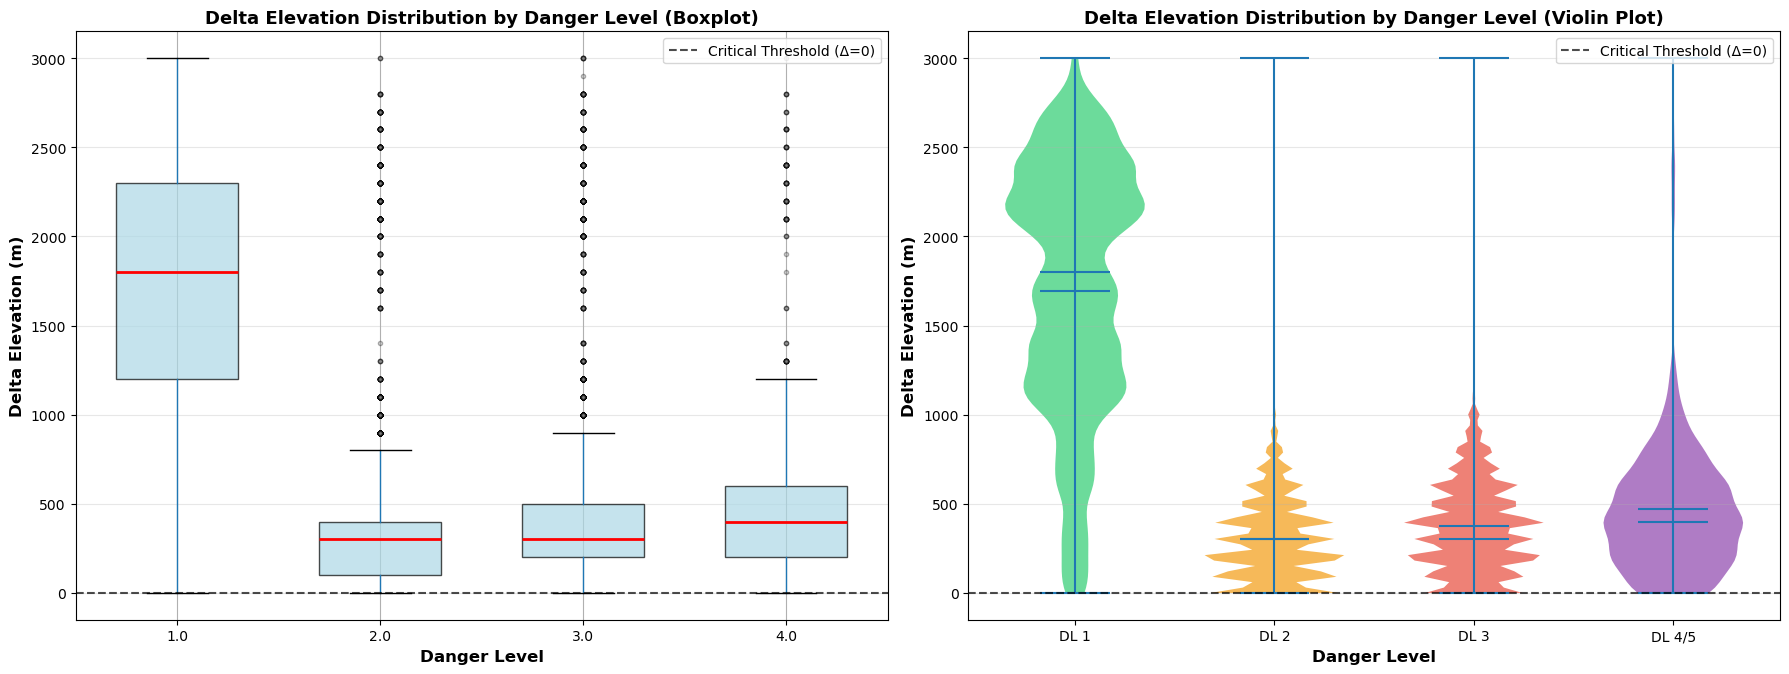


DELTA ELEVATION VALIDATION: Label Quality Check

Median Delta Elevation by Danger Level:
----------------------------------------------------------------------
  DL 1: Median = +1800.0m  |  Above threshold:  98.8%  |  Below:   0.0%
  DL 2: Median = +300.0m  |  Above threshold:  85.3%  |  Below:   0.0%
  DL 3: Median = +300.0m  |  Above threshold:  89.4%  |  Below:   0.0%
  DL 4: Median = +400.0m  |  Above threshold:  92.0%  |  Below:   0.0%

----------------------------------------------------------------------
INTERPRETATION:
----------------------------------------------------------------------
✓ Positive Δ-elevation = Station ABOVE critical elevation (higher danger)
✓ Negative Δ-elevation = Station BELOW critical elevation (safer)

Expected Pattern:
  • DL 1/2: Mixed (both positive and negative values)
  • DL 3/4: Predominantly POSITIVE (stations in danger zone)

Label Noise Detection:
  ✓ No significant label noise detected



In [9]:
# Target Label Quality - Delta Elevation by Danger Level
# Check if delta_elevation exists in the dataset
if 'delta_elevation' in avalanche_season.columns:
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Target Label Quality: Delta Elevation by Danger Level', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    # 1. Boxplot
    ax1 = axes[0]
    avalanche_season.boxplot(column='delta_elevation', by='dangerLevel', ax=ax1,
                              patch_artist=True, widths=0.6,
                              boxprops=dict(facecolor='lightblue', alpha=0.7),
                              medianprops=dict(color='red', linewidth=2),
                              flierprops=dict(marker='o', markerfacecolor='gray', 
                                            markersize=3, alpha=0.3))
    ax1.set_title('Delta Elevation Distribution by Danger Level (Boxplot)', 
                  fontsize=13, fontweight='bold')
    ax1.set_xlabel('Danger Level', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Delta Elevation (m)', fontsize=12, fontweight='bold')
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7, 
                label='Critical Threshold (Δ=0)')
    ax1.grid(axis='y', alpha=0.3)
    ax1.legend(loc='upper right')
    plt.suptitle('')  # Remove automatic title from boxplot
    
    # 2. Violin Plot
    ax2 = axes[1]
    parts = ax2.violinplot([avalanche_season[avalanche_season['dangerLevel'] == dl]['delta_elevation'].dropna() 
                            for dl in [1, 2, 3, 4]],
                           positions=[1, 2, 3, 4],
                           widths=0.7,
                           showmeans=True,
                           showmedians=True)
    
    # Color the violins by danger level
    colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad']
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
    
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7,
                label='Critical Threshold (Δ=0)')
    ax2.set_title('Delta Elevation Distribution by Danger Level (Violin Plot)', 
                  fontsize=13, fontweight='bold')
    ax2.set_xlabel('Danger Level', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Delta Elevation (m)', fontsize=12, fontweight='bold')
    ax2.set_xticks([1, 2, 3, 4])
    ax2.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
    ax2.grid(axis='y', alpha=0.3)
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display statistics
    print("\n" + "="*70)
    print("DELTA ELEVATION VALIDATION: Label Quality Check")
    print("="*70)
    print("\nMedian Delta Elevation by Danger Level:")
    print("-" * 70)
    
    for dl in [1, 2, 3, 4]:
        delta_vals = avalanche_season[avalanche_season['dangerLevel'] == dl]['delta_elevation'].dropna()
        median_delta = delta_vals.median()
        pct_positive = (delta_vals > 0).mean() * 100
        pct_negative = (delta_vals < 0).mean() * 100
        
        print(f"  DL {dl}: Median = {median_delta:+6.1f}m  |  "
              f"Above threshold: {pct_positive:5.1f}%  |  Below: {pct_negative:5.1f}%")
    
    print("\n" + "-" * 70)
    print("INTERPRETATION:")
    print("-" * 70)
    print("✓ Positive Δ-elevation = Station ABOVE critical elevation (higher danger)")
    print("✓ Negative Δ-elevation = Station BELOW critical elevation (safer)")
    print("\nExpected Pattern:")
    print("  • DL 1/2: Mixed (both positive and negative values)")
    print("  • DL 3/4: Predominantly POSITIVE (stations in danger zone)")
    print("\nLabel Noise Detection:")
    
    # Check for suspicious cases
    dl4_negative = avalanche_season[(avalanche_season['dangerLevel'] == 4) & 
                                     (avalanche_season['delta_elevation'] < -200)]
    if len(dl4_negative) > 0:
        pct_noise = (len(dl4_negative) / len(avalanche_season[avalanche_season['dangerLevel'] == 4])) * 100
        print(f"  ⚠️ Warning: {len(dl4_negative)} DL4 cases ({pct_noise:.1f}%) have Δ < -200m")
        print(f"     → Possible label noise (low-elevation stations incorrectly labeled)")
    else:
        print("  ✓ No significant label noise detected")
    
    print("="*70 + "\n")
    
else:
    print("⚠️ Warning: 'delta_elevation' column not found in the dataset.")
    print("This feature should be created during preprocessing as:")
    print("delta_elevation = elevation_station - critical_elevation_from_region")

### **2.2 Meteorological Drivers of Instability**
The "Big Drivers" Boxplots: Create boxplots of key meteorological variables grouped by dangerLevel.

HN72_24 (3-day new snow): Should show a very strong positive correlation with DL.

VW (Wind): Should be higher for DL3/4 (drifting snow problem).

TA (Air Temp): Might show a complex relationship (danger can be high when very cold or very warm).

Stability Index Validation: Boxplots of your imputed stability indices (Sn, ccl_pwl, etc.) by dangerLevel.

Expectation: These should decrease as danger increases.

Sanity Check: Do the imputed values (6.0 or 4.0) correctly cluster in DL1/DL2?

### **2.3 Spatial Dependencies & Patterns**

This is unique to your project. You need to prove that spatial context matters.

Elevation Dependency: Scatter plot (or 2D histogram) of elevation_station vs. dangerLevel.

Goal: Confirm that higher elevations generally see higher danger.

The delta_elevation check: Boxplot of your new delta_elevation feature by dangerLevel.

Expectation: DL3 and DL4 should have mostly positive delta_elevation values. DL1 should be mixed.

Spatial Autocorrelation (Visual): Plot the station values for a single high-danger day on a map.

Why? Do you see clusters of red (DL4)? Or is it random noise? A CNN relies on these clusters existing.

### **2.4 Seasonal Trends and Autocorrelation**

Avalanche danger is path-dependent; it depends on what happened yesterday and last week.

Time Series visualization: Plot dangerLevel, HN24 (daily snow), and HS_mod (total snow) together for one major station (e.g., Weissfluhjoch WFJ2) over one full winter season.

Goal: See if spikes in HN24 immediately precede spikes in dangerLevel.

Persistence check: What is the probability that today's danger level is the same as yesterday's?

Why? A "naive" model that just predicts yesterday's value is surprisingly hard to beat. You need to know this baseline accuracy.

### **2.5 Multicollinearity Analysis**